# Own implementation of the EDMD algorithm (task 2) and application to two examples (tasks 3 and 4)

The Extended Dynamic Mode Decomposition (EDMD) is a method to approximate the Koopman operator $\mathbf{K}$ and the correpsonding triples of Koopman eigenvalue, eigenfunction and mode. Where $\{(\mu_k, \phi_k, v_k)\}^K_{k=1}$ is the set of K triples required to reconstruct the full state. (See Williams et al., 2015)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.linalg

### Task 2: Own implementation of the EDMD algorithm

Requirements:\
Data set with 'labeled data', i.e. $F(x_i) = y_i$\
Dictionary of observables, i.e. basisfunctions (best choice depends on data set)

In [2]:
# Calculate Koopman operator K
def calc_K(X, Y, D):
    M = np.shape(X)[1]
    # evaluate D with values from X
    phi_x = []
    for i in range(M):
        phi_x.append(D(X[0,i],X[1,i]))
    phi_x = np.array(phi_x)
    # evaluate D with values from Y
    phi_y = []
    for i in range(M):
        phi_y.append(D(Y[0,i],Y[1,i]))
    phi_y = np.array(phi_y)
    # calulate G and A matrices
    G = 1/M * phi_x.T @ phi_x
    A = 1/M * phi_x.T @ phi_y
    # solve for K
    K = np.linalg.pinv(G) @ A
    return K

Eigenfunction of $\mathbf{K}$: $\phi_j = \Psi \zeta_j$ with $\zeta_j$ being the j-th eigenvector of $\mathbf{K}$

In [3]:
# caluclate eigenvalues, -vectors, -functions
def calc_eig(K, D):
    eigenvalues, left_evecs, right_evecs = scipy.linalg.eig(K, left=True, right=True)
    #sort eigenvalues (and associated eigenvectors) from big to small
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    right_evecs = right_evecs[:, idx]
    left_evecs = left_evecs[:,idx]#return left eigenvectors for mode calculation
    #calculate eigenfunctions
    eigenfunctions = lambda x, y : D(x,y) @ right_evecs
    return eigenvalues, left_evecs, eigenfunctions

Koopman modes: $\mathbf{V} = (\mathbf{W}^* \mathbf{B})^T$ with $\mathbf{W}^*$ holding the left eigenvectors.

In [4]:
# calculate the Koopman modes
def calc_modes(eigenvectors, B):#problematic because of B!!
    #eigenvectors_inverted = np.linalg.inv(eigenvectors)
    #B = np.zeros((np.shape(eigenvectors)[-1], dim))#2)) #B should be (K,N) where N is dim of data points
    #B[1,0] = 1# for the example from Williams et al.
    #B[5,1] = 1# for the example from Williams et al.
    #B = np.ones((np.shape(eigenvectors)[-1], dim))
    #try with left eigenvectors for full state observable
    modes = (eigenvectors @ B).T    
    return modes

In [5]:
# perform EDMD algorithm
def EDMD(X, Y, D, B=None):
    K = calc_K(X, Y, D)
    eigenvalues, eigenvectors, eigenfunctions = calc_eig(K, D)
    if B is None:
        B = np.ones((np.shape(eigenvectors)[-1], np.shape(X)[1]))
    modes = calc_modes(eigenvectors, B)
    return eigenvalues, eigenvectors, modes, eigenfunctions, K

### Task 3: Linear example from Williams et al., 2015
Analyical solution vs. EDMD approximation with our code (vs. Williams' solution in the report)\
Example: $x(n+1) = Jx(n) = \begin{bmatrix} 0.9 & -0.1 \\ 0.0 & 0.8 \end{bmatrix} x(n)$

Analytical solution:

In [6]:
# analytical solution for eigenfunctions and -values
def sol_func(x, y, i, j):
    return ((x - y)/(2**(1/2)))**i * y**j

def sol_evals(i, j):
    return (0.9)**i * (0.8)**j

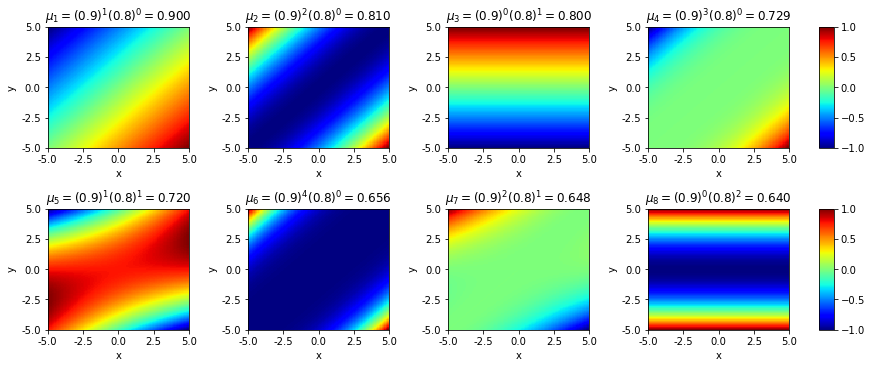

In [7]:
# plot first 8 nontrivial eigenfunctions (+ scaling) like in Williams et al. 2015 - analytical Koopman eigenfunctions
x = np.linspace(-5,5,100)
y = np.linspace(-5,5,100)
X, Y = np.meshgrid(x, y)
fig, axs = plt.subplots(2,4, figsize=(12,5), constrained_layout=True)
cmap = mpl.cm.jet
ij = [(1,0),(2,0),(0,1),(3,0),(1,1),(4,0),(2,1),(0,2)]
for i in range(1,9):
    values = sol_func(X,Y, *ij[i-1])
    ax = axs.flat[i-1]
    pcm = ax.pcolormesh(np.real(values), cmap=cmap)
    ax.set_xticks([0,25,50,75,100])
    ax.set_xticklabels(np.linspace(-5,5,5))
    ax.set_yticks([0,25,50,75,100])
    ax.set_yticklabels(np.linspace(-5,5,5))
    ax.set_title('$\mu_{%d}=(0.9)^{%d}(0.8)^{%d}=%.3f$' %(i,*ij[i-1],sol_evals(*ij[i-1])))
    #ax.set_title('{:.3f}'.format(eigenvalues[i]))#for complex numbers, but here im-part=0
    ax.set_xlabel('x')
    ax.set_ylabel('y')


norm = mpl.colors.Normalize(vmin=-1, vmax=1)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[0,:])
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[1,:])
plt.show()

Solution with EDMD:

In [8]:
# Create the data
J = np.array([[0.9, -0.1],[0.0, 0.8]])
# X normal distributed with size (2,100)
X_data = np.random.default_rng().normal(size=(2,100))
# Y as result of J @ X
Y_data = J @ X_data

In [9]:
# Create the dictionary like in Williams et al. 2015
# define Hermite polynomials
def H0(x):
    return 1
def H1(x):
    return 2 * x
def H2(x):
    return 4 * x**2 - 2
def H3(x):
    return 8 * x**3 - 12 * x
def H4(x):
    return 16 * x**4 - 48 * x**2 + 12

# define dictionary
D = lambda x,y : [H0(x) * H0(y),H0(x)*H1(y),H0(x) * H2(y),H0(x)*H3(y),H0(x) * H4(y),
                  H1(x) * H0(y),H1(x)*H1(y),H1(x) * H2(y),H1(x)*H3(y),H1(x) * H4(y),
                  H2(x) * H0(y),H2(x)*H1(y),H2(x) * H2(y),H2(x)*H3(y),H2(x) * H4(y),
                  H3(x) * H0(y),H3(x)*H1(y),H3(x) * H2(y),H3(x)*H3(y),H3(x) * H4(y),
                  H4(x) * H0(y),H4(x)*H1(y),H4(x) * H2(y),H4(x)*H3(y),H4(x) * H4(y)]

In [11]:
B = np.zeros((25, 2))#B should be (K,N) where N is dim of data points
B[1,0] = 1# for the example from Williams et al.
B[5,1] = 1# for the example from Williams et al.

# apply EDMD to obtain eigenvalues and eigenfunctions
eigenvalues, eigenvectors, modes, eigenfunctions, K = EDMD(X_data, Y_data, D, B)

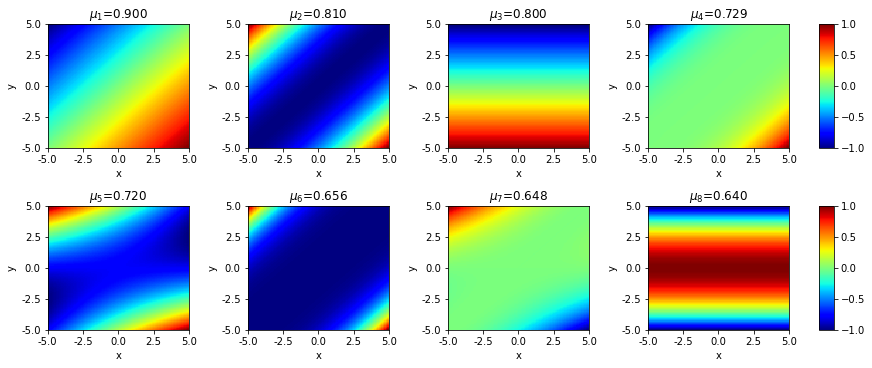

In [12]:
# plot first 8 nontrivial eigenfunctions (+ scaling) like in Williams et al. 2015 - EDMD Koopman eigenfunctions
x = np.linspace(-5,5,100)
y = np.linspace(-5,5,100)
X, Y = np.meshgrid(x, y)
fig, axs = plt.subplots(2,4, figsize=(12,5), constrained_layout=True)
cmap = mpl.cm.jet
for i in range(1,9):
    values = eigenfunctions(X,Y)[i]
    ax = axs.flat[i-1]
    pcm = ax.pcolormesh(np.real(values), cmap=cmap)
    ax.set_xticks([0,25,50,75,100])
    ax.set_xticklabels(np.linspace(-5,5,5))
    ax.set_yticks([0,25,50,75,100])
    ax.set_yticklabels(np.linspace(-5,5,5))
    ax.set_title('$\mu_{%d}$=%.3f' %(i,np.real(eigenvalues[i])))
    #ax.set_title('{:.3f}'.format(eigenvalues[i]))#for complex numbers, but here im-part=0
    ax.set_xlabel('x')
    ax.set_ylabel('y')


norm = mpl.colors.Normalize(vmin=-1, vmax=1)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[0,:])
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[1,:])
plt.show()

In [13]:
#in Li et al. right and left eigenvectors are switched

Next, compare reconstruction based on analytically and numerically (EDMD) obtained Koopman eigenvalues, eigenfunctions, and modes.

c:\users\ludwig\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


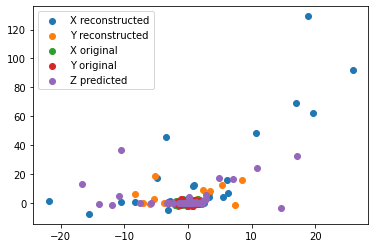

In [14]:
# Reconstruction of X and Y using the Koopman decomposition
t = 1#one time step -> Y
x_rec = modes @ eigenfunctions(X_data[0,:],X_data[1,:])
y_rec = t * eigenvalues * modes @ eigenfunctions(X_data[0,:],X_data[1,:])
t = 2#two time steps -> Z
z = t * eigenvalues * modes @ eigenfunctions(X_data[0,:],X_data[1,:])
X_rec = np.array((x_rec[0], x_rec[1]))
Y_rec = np.array((y_rec[0], y_rec[1]))
Z = np.array((z[0], z[1]))

plt.scatter(X_rec[0,:], X_rec[1,:], label='X reconstructed')
plt.scatter(Y_rec[0,:], Y_rec[1,:], label='Y reconstructed')
plt.scatter(X_data[0,:], X_data[1,:], label='X original')
plt.scatter(Y_data[0,:], Y_data[1,:], label='Y original')
plt.scatter(Z[0,:], Z[1,:], label='Z predicted')
plt.legend()
plt.show()

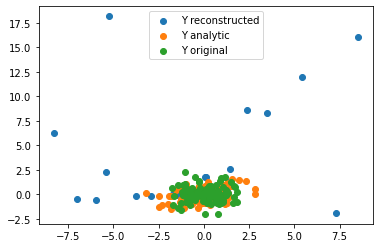

In [15]:
# compare to analytical reconstruction with eigenvalues, -functions from above and modes from Williams et al.
# according to Williams et al. only the 1st and 3rd nontrivial triples are important
my_evals = np.array((sol_evals(*ij[0]), sol_evals(*ij[2])))
my_modes = np.array([[0, -2**(1/2)],[-1, -1]])
my_funcs = lambda x,y : [sol_func(x,y, *ij[0]), sol_func(x,y, *ij[2])]
Y_anl = my_evals * my_modes @ my_funcs(X_data[0,:], X_data[1,:])

plt.scatter(Y_rec[0,:], Y_rec[1,:], label='Y reconstructed')
plt.scatter(Y_anl[0,:], Y_anl[1,:], label='Y analytic')
plt.scatter(Y_data[0,:], Y_data[1,:], label='Y original')
plt.legend()
plt.show()

In [16]:
my_modes# or my modes.T above? -> see williams

array([[ 0.        , -1.41421356],
       [-1.        , -1.        ]])

### Task 4: Example from crowd dynamics
Using the example from exercise 5 task 5: 'MI_timesteps.txt' containing the number of pedestrians in varoius measurement areas at campus Garching. The EDMD algorithm can be applied to a single, multiple, or all measurement areas as demonstrated below.\
In the report: interpretation (and compare to datafold code)

Shape of whole data set: (14001, 10)
Shape of X1: (14000, 1)
Shape of Y1: (14000, 1)
Shape of all_X: (14000, 9)
Shape of all_Y: (14000, 9)


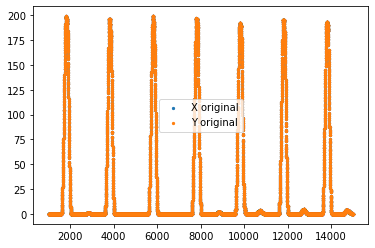

In [17]:
# load data
data = np.loadtxt(fname='MI_timesteps.txt', skiprows=1001)#skipping description + 1000 time steps (burn-in period)
print('Shape of whole data set: '+str(np.shape(data)))
T = data[:,0]#time
X1 = data[:,1]#measurement areas 1-9
X2 = data[:,2]
X3 = data[:,3]
X4 = data[:,4]
X5 = data[:,5]
X6 = data[:,6]
X7 = data[:,7]
X8 = data[:,8]
X9 = data[:,9]

Y1 = X1[1:]# if X is timestep n, Y is timestep n+1
X1 = X1[:-1]#last element cannot be used
X1 = X1.reshape((np.size(X1),1))
Y1 = Y1.reshape((np.size(Y1),1))
print('Shape of X1: '+str(np.shape(X1)))
print('Shape of Y1: '+str(np.shape(Y1)))

all_X = data[:,1:]
all_Y = all_X[1:,:]
all_X = all_X[:-1,:]
print('Shape of all_X: '+str(np.shape(all_X)))
print('Shape of all_Y: '+str(np.shape(all_Y)))
plt.scatter(T[:-1], X1, label='X original', s=5)
plt.scatter(T[1:], Y1, label='Y original', s=5)
plt.legend()
plt.show()

In [18]:
# apply EDMD to obtain eigenvalues and eigenfunctions
evals, evecs, mos, efuncs, _ = EDMD(X1, Y1, D)

In [19]:
np.shape(X1)

(14000, 1)

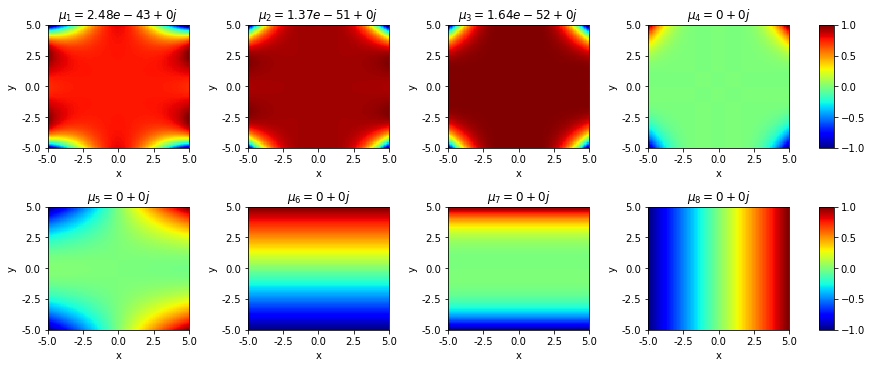

In [20]:
# only X1
x = np.linspace(-5,5,100)
y = np.linspace(-5,5,100)
X, Y = np.meshgrid(x, y)
fig, axs = plt.subplots(2,4, figsize=(12,5), constrained_layout=True)
cmap = mpl.cm.jet
for i in range(1,9):
    values = efuncs(X,Y)[i]
    ax = axs.flat[i-1]
    pcm = ax.pcolormesh(np.real(values), cmap=cmap)
    ax.set_xticks([0,25,50,75,100])
    ax.set_xticklabels(np.linspace(-5,5,5))
    ax.set_yticks([0,25,50,75,100])
    ax.set_yticklabels(np.linspace(-5,5,5))
    #ax.set_title('$\mu_{%d}=%.3g$' %(i,np.real(evals[i])))
    ax.set_title('$\mu_{:d}={:.3g}$'.format(i,evals[i]))#for complex numbers
    ax.set_xlabel('x')
    ax.set_ylabel('y')


norm = mpl.colors.Normalize(vmin=-1, vmax=1)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[0,:])
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[1,:])
plt.show()

(1,)
(14000, 1)
234243580.07258987
(3252.953202253698+0j)


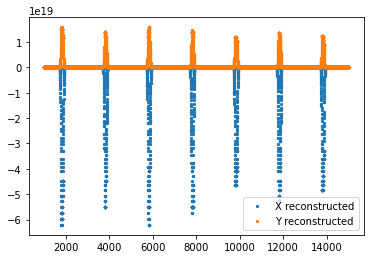

In [21]:
# Reconstruction of X1 and Y1 using the Koopman decomposition
t = 1#one time step -> Y
x_rec = mos @ efuncs(X1,X1)
print(np.shape(x_rec))
y_rec = t * evals * mos @ efuncs(X1,X1)
X_rec = np.array((x_rec[0]))#, x_rec[1]))
Y_rec = np.array((y_rec[0]))#, y_rec[1]))
#plot over time , what to do with function?
print(np.shape(X_rec))
#plt.scatter(T[:-1], -X_rec/X_rec.max(), label='X reconstructed')
#plt.scatter(T[1:], Y_rec/Y_rec.max(), label='Y reconstructed')
plt.scatter(T[:-1], X_rec, label='X reconstructed', s=5)
plt.scatter(T[1:], Y_rec, label='Y reconstructed', s=5)
print(X_rec.max())
print(np.mean(((Y_rec/Y_rec.max())-Y1)**2))
#plt.scatter(T[:-1], X1, label='X original')
#plt.scatter(T[1:], Y1, label='Y original')
plt.legend()
plt.show()

In [22]:
# apply EDMD to obtain eigenvalues and eigenfunctions
all_evals, all_evecs, all_mos, all_efuncs, _ = EDMD(all_X, all_Y, D)

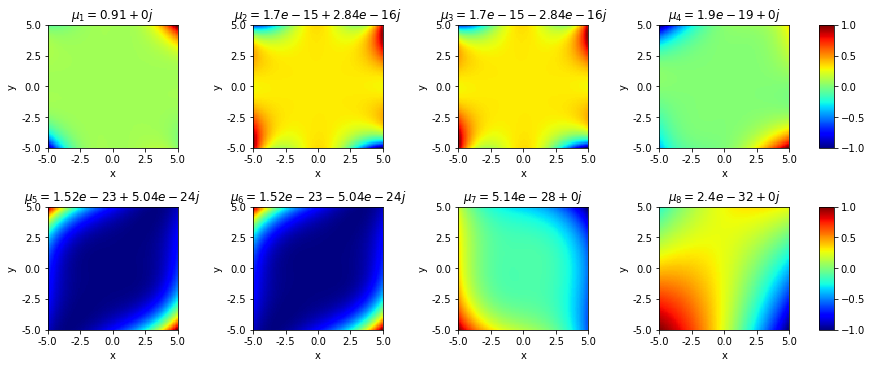

In [23]:
x = np.linspace(-5,5,100)
y = np.linspace(-5,5,100)
X, Y = np.meshgrid(x, y)
fig, axs = plt.subplots(2,4, figsize=(12,5), constrained_layout=True)
cmap = mpl.cm.jet
for i in range(1,9):
    values = all_efuncs(X,Y)[i]
    ax = axs.flat[i-1]
    pcm = ax.pcolormesh(np.real(values), cmap=cmap)
    ax.set_xticks([0,25,50,75,100])
    ax.set_xticklabels(np.linspace(-5,5,5))
    ax.set_yticks([0,25,50,75,100])
    ax.set_yticklabels(np.linspace(-5,5,5))
    #ax.set_title('$\mu_{%d}=%.3g$' %(i,np.real(all_evals[i])))
    ax.set_title('$\mu_{:d}={:.3g}$'.format(i,all_evals[i]))#for complex numbers
    ax.set_xlabel('x')
    ax.set_ylabel('y')


norm = mpl.colors.Normalize(vmin=-1, vmax=1)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[0,:])
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[1,:])
plt.show()

In [24]:
np.shape(all_X)

(14000, 9)

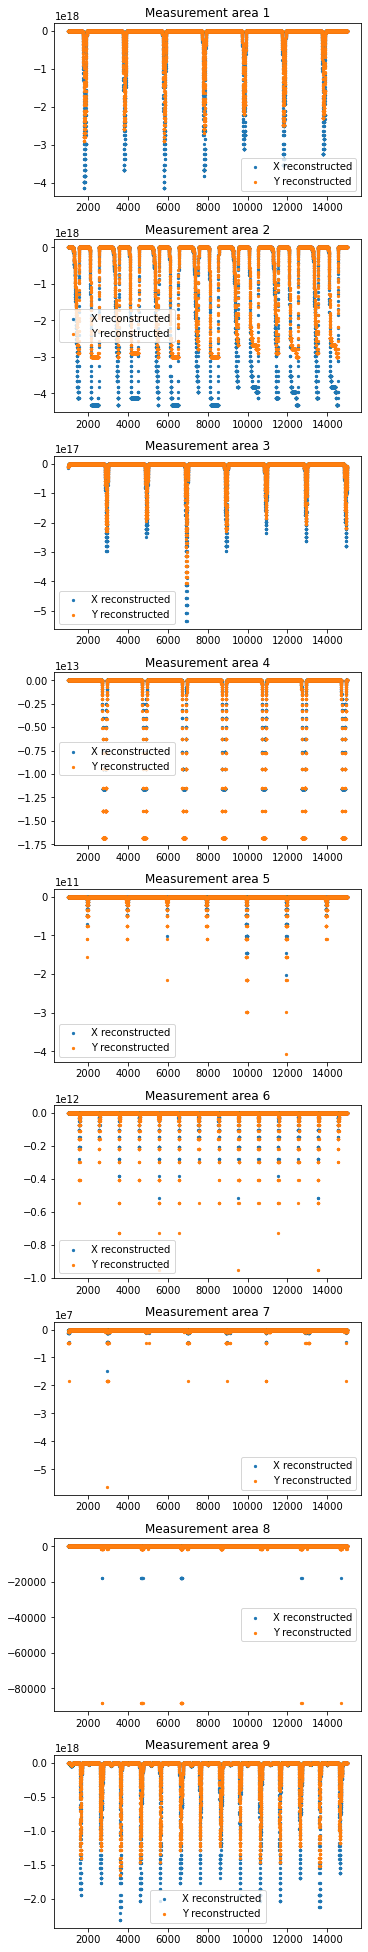

In [25]:
# Reconstruction of X and Y for all measurement areas
fig, axs = plt.subplots(9,1, figsize=(5,27), constrained_layout=True)
for i in range(0,9):
    #plt.subplot(9,1,i+1)
    ax=axs.flat[i]
    t = 1#one time step -> Y
    x_rec = all_mos @ all_efuncs(all_X[:,i],all_X[:,i])
    y_rec = t * all_evals * all_mos @ all_efuncs(all_X[:,i],all_X[:,i])
    X_rec = np.array((x_rec[0], x_rec[1], x_rec[2], x_rec[3], x_rec[4], x_rec[5], x_rec[6], x_rec[7], x_rec[8]))
    Y_rec = np.array((y_rec[0], y_rec[1], y_rec[2], y_rec[3], y_rec[4], y_rec[5], y_rec[6], y_rec[7], y_rec[8]))
    ax.scatter(T[:-1], X_rec[1,:], label='X reconstructed', s=5)
    ax.scatter(T[1:], Y_rec[0,:], label='Y reconstructed', s=5)
    ax.set_title('Measurement area {:d}'.format(i+1))
    ax.legend()

EDMD with datafold code:

In [37]:
import csv
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
from datafold.pcfold import TSCDataFrame, GaussianKernel
from datafold.dynfold import DMDFull
from datafold.dynfold.transform import TSCRadialBasis, TSCPolynomialFeatures
from datafold.appfold import EDMD

In [39]:
df = pd.read_csv('MI_timesteps.txt', sep=" ")
df = df.drop(['timeStep'], axis=1)
df = df = df.iloc[1000:]
tsc_data = TSCDataFrame.from_single_timeseries(df)

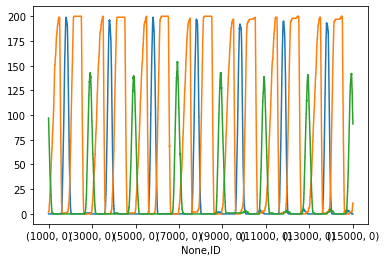

In [40]:
df['areaDensityCounting-PID5'].plot()
df['areaDensityCounting-PID6'].plot()
df['areaDensityCounting-PID7'].plot()

In [41]:
tsc_data

feature   areaDensityCounting-PID5  areaDensityCounting-PID6  \
ID time                                                        
0  1000                          0                         2   
   1001                          0                         2   
   1002                          0                         2   
   1003                          0                         2   
   1004                          0                         2   
...                            ...                       ...   
   14996                         0                        10   
   14997                         0                        10   
   14998                         0                        10   
   14999                         0                        10   
   15000                         0                        11   

feature   areaDensityCounting-PID7  areaDensityCounting-PID8  \
ID time                                                        
0  1000                         97                         7   
   1001                         96                         7   
   1002                         95                         6   
   1003                         94                         6   
   1004                         92                         6   
...                            ...                       ...   
   14996                        95                         4   
   14997                        94                         3   
   14998                        93                         3   
   14999                        93                         3   
   15000                        91                         2   

feature   areaDensityCounting-PID9  areaDensityCounting-PID10  \
ID time                                                         
0  1000                          0                          0   
   1001                          0                          0   
   1002                          0                          0   
   1003                          0                          0   
   1004                          0                          0   
...                            ...                        ...   
   14996                         0                          0   
   14997                         0                          0   
   14998                         0                          1   
   14999                         0                          1   
   15000                         0                          0   

feature   areaDensityCounting-PID11  areaDensityCounting-PID12  \
ID time                                                          
0  1000                           5                          1   
   1001                           5                          1   
   1002                           5                          0   
   1003                           4                          1   
   1004                           5                          0   
...                             ...                        ...   
   14996                          2                          1   
   14997                          3                          1   
   14998                          2                          1   
   14999                          3                          1   
   15000                          1                          0   

feature   areaDensityCounting-PID13  
ID time                              
0  1000                          43  
   1001                          45  
   1002                          46  
   1003                          46  
   1004                          46  
...                             ...  
   14996                         39  
   14997                         39  
   14998                         40  
   14999                         41  
   15000                         42  

[14001 rows x 9 columns]

EDMD with identity dictionary:

In [42]:
dmd = DMDFull().fit(X=tsc_data, store_koopman_matrix=True)  # must be TSCDataFrame
dmd_values = dmd.predict(tsc_data.initial_states(), time_values=None)

# Will be a red line in the plot
#dmd_values_oos = dmd.predict(np.array([-1.8, 2]), time_values=np.linspace(0, 100, 1000))

print("Data snipped with predicted time series data")
dmd_values

Data snipped with predicted time series data


feature   areaDensityCounting-PID5  areaDensityCounting-PID6  \
ID time                                                        
0  1000               1.210143e-14                  2.000000   
   1001              -1.224676e-01                  2.244369   
   1002              -1.859633e-01                  2.503428   
   1003              -2.071541e-01                  2.772768   
   1004              -1.978603e-01                  3.049641   
...                            ...                       ...   
   14996              1.528385e+01                 59.823557   
   14997              1.528357e+01                 59.822446   
   14998              1.528329e+01                 59.821335   
   14999              1.528300e+01                 59.820225   
   15000              1.528272e+01                 59.819114   

feature   areaDensityCounting-PID7  areaDensityCounting-PID8  \
ID time                                                        
0  1000                  97.000000                  7.000000   
   1001                  96.297722                  6.874682   
   1002                  95.650442                  6.720674   
   1003                  95.039919                  6.547123   
   1004                  94.453548                  6.360357   
...                            ...                       ...   
   14996                  9.839230                  3.221742   
   14997                  9.839047                  3.221682   
   14998                  9.838864                  3.221622   
   14999                  9.838682                  3.221562   
   15000                  9.838499                  3.221503   

feature   areaDensityCounting-PID9  areaDensityCounting-PID10  \
ID time                                                         
0  1000               1.372166e-15              -8.187895e-15   
   1001               3.177831e-03               4.105778e-02   
   1002               6.680682e-03               6.415351e-02   
   1003               1.041067e-02               7.439983e-02   
   1004               1.430464e-02               7.544100e-02   
...                            ...                        ...   
   14996              7.772877e-01               1.297591e+00   
   14997              7.772733e-01               1.297567e+00   
   14998              7.772589e-01               1.297542e+00   
   14999              7.772444e-01               1.297518e+00   
   15000              7.772300e-01               1.297494e+00   

feature   areaDensityCounting-PID11  areaDensityCounting-PID12  \
ID time                                                          
0  1000                    5.000000                   1.000000   
   1001                    4.377787                   0.749011   
   1002                    3.915899                   0.577694   
   1003                    3.571903                   0.461057   
   1004                    3.314712                   0.381862   
...                             ...                        ...   
   14996                   0.339481                   0.058524   
   14997                   0.339475                   0.058523   
   14998                   0.339469                   0.058522   
   14999                   0.339462                   0.058521   
   15000                   0.339456                   0.058520   

feature   areaDensityCounting-PID13  
ID time                              
0  1000                   43.000000  
   1001                   43.854051  
   1002                   44.574112  
   1003                   45.198592  
   1004                   45.754639  
...                             ...  
   14996                  35.267746  
   14997                  35.267092  
   14998                  35.266437  
   14999                  35.265782  
   15000                  35.265127  

[14001 rows x 9 columns]

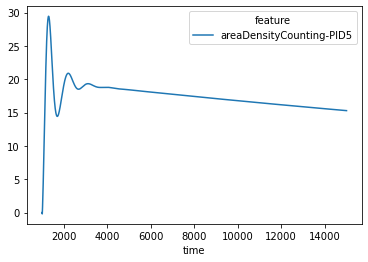

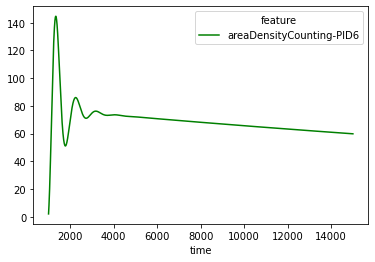

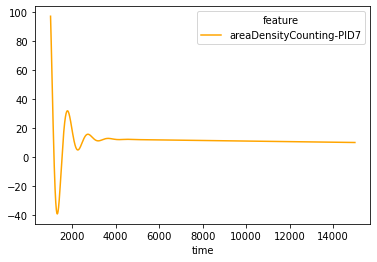

In [43]:
dmd_values['areaDensityCounting-PID5'].plot()
dmd_values['areaDensityCounting-PID6'].plot(color = 'green')
dmd_values['areaDensityCounting-PID7'].plot(color = 'orange')

EDMD with dictionary of polynomials of degree 3:

In [49]:
dict_step = [
    (
        "polynomial",
        TSCPolynomialFeatures(degree=2),
    )
]

edmd_poly = EDMD(dict_steps=dict_step, include_id_state=True).fit(X=tsc_data)
edmd_poly_values = edmd_poly.predict(tsc_data.initial_states())

In [50]:
# access models in the dictionary, the name was given in "dict_step" above
print(edmd_poly.named_steps["polynomial"])

print("")
print("polynomial degrees for data")
print(edmd_poly.named_steps["polynomial"].powers_)

print("")
print("Dictionary space values:")
edmd_p = edmd_poly.reconstruct(tsc_data)#transform(tsc_data)
edmd_p

TSCPolynomialFeatures(degree=2, include_bias=False, include_first_order=False,
                      interaction_only=False)

polynomial degrees for data
[[2 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0]
 [1 0 0 1 0 0 0 0 0]
 [1 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 1]
 [0 2 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0]
 [0 1 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 0 1]
 [0 0 2 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0]
 [0 0 1 0 0 1 0 0 0]
 [0 0 1 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 1]
 [0 0 0 2 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0]
 [0 0 0 1 0 1 0 0 0]
 [0 0 0 1 0 0 1 0 0]
 [0 0 0 1 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 1]
 [0 0 0 0 2 0 0 0 0]
 [0 0 0 0 1 1 0 0 0]
 [0 0 0 0 1 0 1 0 0]
 [0 0 0 0 1 0 0 1 0]
 [0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 1 0 0 1]
 [0 0 0 0 0 0 2 0 0]
 [0 0 

feature   areaDensityCounting-PID5  areaDensityCounting-PID6  \
ID time                                                        
0  1000               7.818860e-12                  2.000000   
   1001              -4.304853e-02                  1.989705   
   1002              -8.371953e-02                  2.032754   
   1003              -1.238736e-01                  2.097712   
   1004              -1.631295e-01                  2.172463   
...                            ...                       ...   
   14996              2.231223e+01                 85.992840   
   14997              2.231223e+01                 85.992816   
   14998              2.231222e+01                 85.992792   
   14999              2.231221e+01                 85.992769   
   15000              2.231221e+01                 85.992745   

feature   areaDensityCounting-PID7  areaDensityCounting-PID8  \
ID time                                                        
0  1000                  97.000000                  7.000000   
   1001                  96.502116                  6.806742   
   1002                  95.888221                  6.604615   
   1003                  95.251239                  6.413092   
   1004                  94.606385                  6.233242   
...                            ...                       ...   
   14996                 15.457666                  5.109202   
   14997                 15.457661                  5.109201   
   14998                 15.457657                  5.109199   
   14999                 15.457653                  5.109198   
   15000                 15.457649                  5.109197   

feature   areaDensityCounting-PID9  areaDensityCounting-PID10  \
ID time                                                         
0  1000               2.036878e-13              -2.028072e-12   
   1001              -1.134815e-02               2.179086e-01   
   1002              -1.737989e-02               3.434840e-01   
   1003              -2.120689e-02               4.352033e-01   
   1004              -2.299931e-02               5.096453e-01   
...                            ...                        ...   
   14996              1.218171e+00               1.927912e+00   
   14997              1.218170e+00               1.927911e+00   
   14998              1.218170e+00               1.927911e+00   
   14999              1.218170e+00               1.927910e+00   
   15000              1.218169e+00               1.927909e+00   

feature   areaDensityCounting-PID11  areaDensityCounting-PID12  \
ID time                                                          
0  1000                    5.000000                   1.000000   
   1001                    4.031685                   0.774844   
   1002                    3.519442                   0.701522   
   1003                    3.201863                   0.676471   
   1004                    2.995627                   0.664964   
...                             ...                        ...   
   14996                   0.535305                   0.090355   
   14997                   0.535305                   0.090355   
   14998                   0.535305                   0.090355   
   14999                   0.535305                   0.090355   
   15000                   0.535305                   0.090355   

feature   areaDensityCounting-PID13  
ID time                              
0  1000                   43.000000  
   1001                   43.605239  
   1002                   44.227284  
   1003                   44.856543  
   1004                   45.492191  
...                             ...  
   14996                  54.171656  
   14997                  54.171642  
   14998                  54.171627  
   14999                  54.171612  
   15000                  54.171597  

[14001 rows x 9 columns]

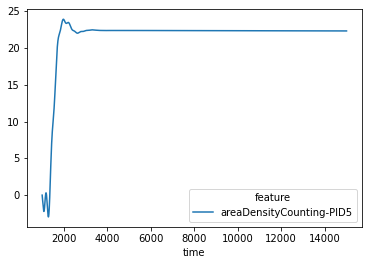

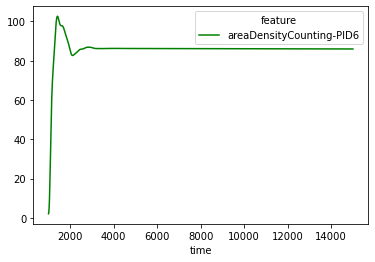

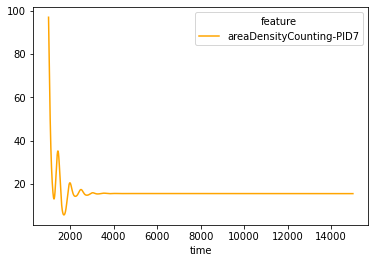

In [54]:
edmd_p['areaDensityCounting-PID5'].plot()
edmd_p['areaDensityCounting-PID6'].plot(color = 'green')
edmd_p['areaDensityCounting-PID7'].plot(color = 'orange')